# Import Statements

In [2]:
from PIL import Image
import sys
from random import randint
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
import imgaug.augmenters as iaa
import imgaug as ia
import matplotlib.pyplot as plt

# Resizing the Images to 1280 by 1280

In [11]:
images = ["Barnacles/cropped_img1.jpg", "Barnacles/cropped_img2.jpg", "Barnacles/cropped_mask1.jpg", "Barnacles/cropped_mask2.jpg"]
for image in images:
    with Image.open(image) as img:
        img = img.resize((1280, 1280))
        new_filename = os.path.basename(image).replace('.jpg', '_resized.jpg')
        img.save(f"Barnacles/crop_and_xml/{new_filename}")
        new_save = os.path.join("Barnacles", new_filename)
        img.save(new_save)
        

# Pascal VOC Formatting

In [3]:
#Then getting the bounding boxes in Pascal VOC formatting
def load_and_create_xml(image_path, xml_path, output_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY_INV)[1]
    contours = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    root = ET.Element("annotation")
    filename = ET.SubElement(root, "filename")
    filename.text = "temp.jpg"
    path = ET.SubElement(root, "path")
    path.text = image_path
    size = ET.SubElement(root, "size")
    ET.SubElement(size, "width").text = '1280'
    ET.SubElement(size, "height").text = '1280'
    ET.SubElement(size, "depth").text = '3'
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
        object_element = ET.SubElement(root, "object")
        ET.SubElement(object_element, "name").text = "Barnacle"
        bndbox = ET.SubElement(object_element, "bndbox")
        ET.SubElement(bndbox, "xmin").text = str(x)
        ET.SubElement(bndbox, "ymin").text = str(y)
        ET.SubElement(bndbox, "xmax").text = str(x + w)
        ET.SubElement(bndbox, "ymax").text = str(y + h)
    tree = ET.ElementTree(root)
    tree.write(xml_path)
    cv2.imwrite(output_path, image)
    
image_path = 'Barnacles/cropped_mask1_resized.jpg'
xml_path = "Barnacles/crop_and_xml/cropped_mask1_bounding_boxes.xml"
output_path = "Barnacles/crop_and_xml/cropped_mask1_bounding_boxes.jpg"
load_and_create_xml(image_path, xml_path, output_path)

image_path = 'Barnacles/cropped_mask2_resized.jpg'
xml_path = "Barnacles/crop_and_xml/cropped_mask2_bounding_boxes.xml"
output_path = "Barnacles/crop_and_xml/cropped_mask2_bounding_boxes.jpg"
load_and_create_xml(image_path, xml_path, output_path)

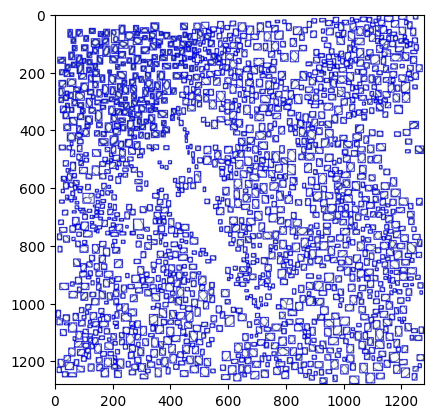

In [5]:
img = Image.open("Barnacles/crop_and_xml/cropped_mask1_bounding_boxes.jpg")
plt.imshow(img)
plt.show()
#Shows the bounding boxes, which I converted to xml

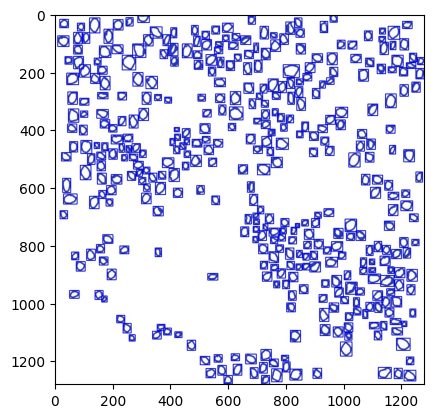

In [6]:
img = Image.open("Barnacles/crop_and_xml/cropped_mask2_bounding_boxes.jpg")
plt.imshow(img)
plt.show()
#Shows more bounding boxes, which I converted to xml

# Split the Images

In [13]:
#Then split the images
overlap = 80
crop_size = 320

def calculate_intersection_area(bou1, bou2):
    xmin1, ymin1, xmax1, ymax1 = bou1
    xmin2, ymin2, xmax2, ymax2 = bou2
    xmin_max = max(xmin1, xmin2)
    ymin_max = max(ymin1, ymin2)
    xmax_min = min(xmax1, xmax2)
    ymax_min = min(ymax1, ymax2)
    if xmax_min > xmin_max and ymax_min > ymin_max:
        return (xmax_min - xmin_max) * (ymax_min - ymin_max)
    else: 
        return 0
    
def process_bounding_boxes(root, ccords):
    new_root = ET.Element("annotation")
    for obj in root.findall('object'):
        bou = obj.find('bndbox')
        xmin = int(bou.find('xmin').text)
        ymin = int(bou.find('ymin').text)
        xmax = int(bou.find('xmax').text)
        ymax = int(bou.find('ymax').text)
        if (xmin < ccords[2] and xmax > ccords[0] and ymin < ccords[3] and ymax > ccords[1]):
            xminc = max(xmin, ccords[0])
            yminc = max(ymin, ccords[1])
            xmaxc = min(xmax, ccords[2])
            ymaxc = min(ymax, ccords[3])
            original_area = (xmax - xmin) * (ymax - ymin)
            intersection_area = calculate_intersection_area((xmin, ymin, xmax, ymax), (xminc, yminc, xmaxc, ymaxc))
            if intersection_area / original_area >= 0.5:
                new_obj = ET.SubElement(new_root, "object")
                newbou = ET.SubElement(new_obj, "bndbox")
                ET.SubElement(newbou, "xmin").text = str(xminc - ccords[0])
                ET.SubElement(newbou, "ymin").text = str(yminc - ccords[1])
                ET.SubElement(newbou, "xmax").text = str(xmaxc - ccords[0])
                ET.SubElement(newbou, "ymax").text = str(ymaxc - ccords[1])
    return new_root if len(new_root) > 0 else None

def save_cropped_image_and_xml(image, root, coords, count, output_dir, number):
    cropped_image = image[coords[1]:coords[3], coords[0]:coords[2]]
    cv2.imwrite(os.path.join(output_dir, f'cropped{number}_{count}.jpg'), cropped_image)
    new_root = process_bounding_boxes(root, coords)
    if new_root is not None:
        new_tree = ET.ElementTree(new_root)
        new_tree.write(os.path.join(output_dir, f'cropped{number}_{count}.xml'))
        
def split_image(image_path, xml_path, output_dir, number):
    image = cv2.imread(image_path)
    height = image.shape[0]
    width = image.shape[1]
    tree = ET.parse(xml_path)
    root = tree.getroot()
    count = 0
    step = crop_size - overlap

    for i in range(0, height-crop_size + 1, step):
        for j in range(0, width-crop_size + 1, step):
            ccords = (j, i, min(j + crop_size, width), min(i + crop_size, height))
            save_cropped_image_and_xml(image, root, ccords, count, output_dir, number)
            count += 1

    for i in range(0, height - crop_size + 1, step):
        j = width - crop_size  
        ccords = (j, i, j + crop_size, i + crop_size)
        save_cropped_image_and_xml(image, root, ccords, count, output_dir, number)
        count += 1

    for j in range(0, width - crop_size + 1, step):
        i = height - crop_size  
        ccords = (j, i, j + crop_size, i + crop_size)
        save_cropped_image_and_xml(image, root, ccords, count, output_dir, number)
        count += 1
        
    ccords = (width - crop_size, height - crop_size, width, height)
    save_cropped_image_and_xml(image, root, ccords, count, output_dir, number)
    count += 1


image_path = 'Barnacles/crop_and_xml/cropped_img1_resized.jpg'
xml_path = 'Barnacles/crop_and_xml/cropped_mask1_bounding_boxes.xml'
output_dir = 'Barnacles/crop_and_xml/split_cropped_masks_new/'
number = 1
split_image(image_path, xml_path, output_dir, number)

image_path = 'Barnacles/crop_and_xml/cropped_img2_resized.jpg'
xml_path = 'Barnacles/crop_and_xml/cropped_mask2_bounding_boxes.xml'
output_dir = 'Barnacles/crop_and_xml/split_cropped_masks_new/'
number = 2
split_image(image_path, xml_path, output_dir, number)


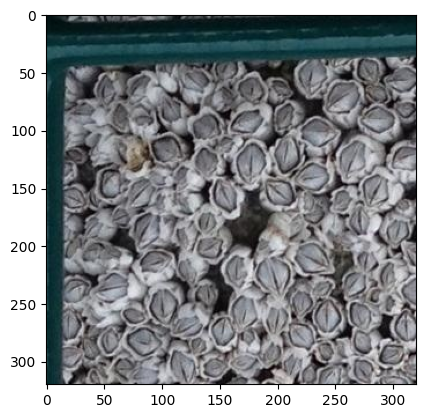

In [9]:
img = Image.open("Barnacles/crop_and_xml/split_cropped_masks_new/cropped1_0.jpg")
plt.imshow(img)
plt.show()
#example of one cropped image, of the top left corner

# Add Necessary Parameters for TF Records in Advance

In [14]:
#This just adds the tags "filename, size (subtags width, height, depth), etc." to match with the default Tensorflow Object Detection create_tf_records Python file
def process_xml_files(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith('.xml'):
            xml_file_path = os.path.join(folder_path, filename)
            tree = ET.parse(xml_file_path)
            root = tree.getroot()

            filename_t = ET.Element('filename')
            filename_t.text = filename.replace('.xml', '.jpg') 
            root.insert(0, filename_t)

            size_t = ET.Element('size')
            width_t = ET.SubElement(size_t, 'width')
            width_t.text = '320'
            height_t = ET.SubElement(size_t, 'height')
            height_t.text = '320'
            depth_t = ET.SubElement(size_t, 'depth')
            depth_t.text = '3'
            root.insert(1, size_t)

            for obj in root.findall('object'):
                name_t = obj.find('name')
                if name_t is None:
                    name_t = ET.Element('name')
                    name_t.text = 'Barnacle'
                    obj.insert(0, name_t) 

                name_index = list(obj).index(name_t) + 1
                pose_t = ET.Element('pose')
                pose_t.text = 'Unspecified'
                obj.insert(name_index, pose_t)
                truncated_t = ET.Element('truncated')
                truncated_t.text = '0'
                obj.insert(name_index + 1, truncated_t)
                difficult_t = ET.Element('difficult')
                difficult_t.text = '0'
                obj.insert(name_index + 2, difficult_t)

            tree.write(xml_file_path)

folder_path = 'Barnacles/crop_and_xml/split_cropped_masks_new/'
process_xml_files(folder_path)


## Then, I dragged the `split_and_cropped_masks_new` folder into the `Tensorflow/workspace/images/` directory.


# Basic Augmentation to Further Increase the Dataset

In [16]:
seq = iaa.Sequential([
    iaa.Fliplr(p=0.5), #flip left right
    iaa.Flipud(p=0.5), #up down
    iaa.Multiply((0.8, 1.2)), #brightness
    iaa.LinearContrast((0.8, 1.2)) #contrast
])

def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bous = []
    for obj in root.findall('object'):
        bx = obj.find('bndbox')
        xmin = int(bx.find('xmin').text)
        ymin = int(bx.find('ymin').text)
        xmax = int(bx.find('xmax').text)
        ymax = int(bx.find('ymax').text)
        bous.append(ia.BoundingBox(xmin, ymin, xmax, ymax))
    return bous, tree

def augment_image(image, bous):
    bbs = ia.BoundingBoxesOnImage(bous, shape=image.shape)
    return seq(image=image, bounding_boxes=bbs)

def save_updated_xml(xml_tree, bous_aug, output_xml_path, image_shape):
    root = xml_tree.getroot()
    objects_to_remove = []
    for obj, bx in zip(root.findall('object'), bous_aug.bounding_boxes):
        bndbox = obj.find('bndbox')
        xmin, ymin = max(0, int(bx.x1)), max(0, int(bx.y1))
        xmax, ymax = min(int(bx.x2), image_shape[1] - 1), min(int(bx.y2), image_shape[0] - 1)
        if xmax < xmin or ymax < ymin:
            objects_to_remove.append(obj)
        else:
            bndbox.find('xmin').text, bndbox.find('ymin').text = str(xmin), str(ymin)
            bndbox.find('xmax').text, bndbox.find('ymax').text = str(xmax), str(ymax)
    for obj in objects_to_remove:
        root.remove(obj)
    xml_tree.write(output_xml_path)

image_d = 'Tensorflow/workspace/images/split_cropped_masks_new/jpg'
xml_d = 'Tensorflow/workspace/images/split_cropped_masks_new/xml'
output_d = 'Tensorflow/workspace/images/new_augmented'

for image_file in os.listdir(image_d):
    if image_file.endswith('.jpg'):
        image_path = os.path.join(image_d, image_file)
        xml_path = os.path.join(xml_d, image_file.replace('.jpg', '.xml'))
        
        image = cv2.imread(image_path)
        bous, xml_tree = parse_xml(xml_path)
        
        for i in range(2):
            image_aug, bbs_aug = augment_image(image, bous)
            cv2.imwrite(os.path.join(output_d, f"aug_{i+1}_{image_file}"), image_aug)
            save_updated_xml(xml_tree, bbs_aug, os.path.join(output_d, f'aug_{i+1}_{image_file.replace(".jpg", ".xml")}'), image.shape)


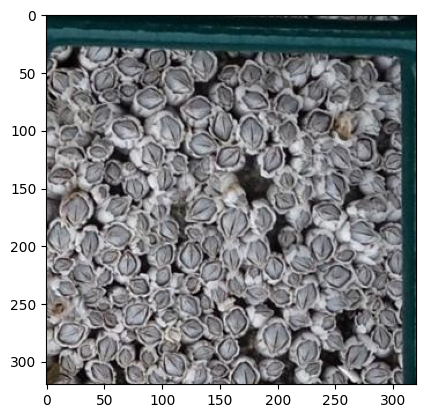

In [11]:
img = Image.open("Tensorflow/workspace/images/new_augmented/aug_1_cropped_0.jpg")
plt.imshow(img)
plt.show()
#example of one augmented image, of the top left corner, that I displayed before

# Renaming Filenames Correctly

In [7]:
#rename the filenames so that they are correct
xml_dir = 'Tensorflow/workspace/images/new_augmented'

for filename in os.listdir(xml_dir):
    if filename.endswith('.xml'):
        xml_path = os.path.join(xml_dir, filename)
        tree = ET.parse(xml_path)
        root = tree.getroot()
        filename_element = root.find('filename')
        if filename_element is not None:
            filename_element.text = filename.replace('.xml', '.jpg')
        tree.write(xml_path)

## Next I manually divided the files in the `new_augmented` folder into the `test` and `train` folders in about a 25-75 split, keeping the `.xml` and `.jpg` files together.
